## Detection of Frontal Eddies Manually

In [1]:
import numpy as np
import xarray as xr
import os.path as op
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date, timedelta, datetime
import cartopy.crs as crs
import hvplot.xarray

Algorithm Steps

0. filter to my area of interest just based on SAB and beyond
1. find the local minima in the image or maybe just find neighborhoods of negative  
2. when tracking just find the center of a negative blob and ensure it is within a couple pixels of the previous location of that blob
3. profit

This is based on https://py-eddy-tracker.readthedocs.io/en/latest/installation.html

In [2]:
ds_ssh = xr.open_dataset('aviso/dataset-duacs-rep-global-merged-allsat-phy-l4_1603205725460.nc')
ds_ssh

<xarray.Dataset>
Dimensions:    (latitude: 63, longitude: 328, time: 1749)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-10-15
  * latitude   (latitude) float32 26.125 26.375 26.625 ... 41.125 41.375 41.625
  * longitude  (longitude) float32 278.125 278.375 278.625 ... 359.625 359.875
Data variables:
    adt        (time, latitude, longitude) float64 ...
    err        (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2020-03-13T10:01:53Z
    date_issued:                     2020-03-13T10:01:53Z
    date_modified:                   2020-03-13T10:01:53Z
    geospatial_lat_max:              41.625
    geospatial_lat_min:              26.125
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              -0.125
    geospatial_lon_min:              -81.875
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2020-03-13 10:01:55Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        Altika Drifting Phase, Cryosat-2, Haiyan...
    processing_level:                L4
    product_version:                 2020
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    software_version:                6.3_DUACS_DT2018_baseline
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-10-15T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2019-10-15T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    History:                         Translated to CF-1.0 Conventions by Netc...

In [3]:
ds_ssh = ds_ssh.sel(time=slice('2019-01-01', '2019-10-15'))
ds_ssh = ds_ssh.sel( latitude=slice(29, 36), longitude=slice(-85+360,-65+360))
ds_ssh = ds_ssh.rename({'longitude':'lon','latitude':'lat'})
ds_ssh['lon'] = ds_ssh['lon']-360

In [4]:
ds_ssh.sla[0].plot(vmin=-.5, vmax=.5, cmap='bwr', figsize=(10,5))

In [5]:
bathy = xr.open_dataset('bathymetry/GEBCO_2020_23_Oct_2020_c3e0a2c71e39/gebco_2020_n41.220703125_s24.7412109375_w-82.6611328125_e-59.765625.nc')
bathy_gs = bathy.sel( lat=slice(29, 36), lon=slice(-85,-65))

In [6]:
interp_bathy = bathy_gs.interp(lat=ds_ssh["lat"], lon=ds_ssh["lon"])
interp_bathy.elevation.plot(vmin=-500,vmax=-20)

In [7]:
ds_cropped = ds_ssh.copy()

In [8]:
ds_cropped['sla'] = ds_cropped.sla.where(interp_bathy.elevation < -50) 
ds_cropped['sla'] = ds_cropped.sla.where(interp_bathy.elevation > -2000) 

In [9]:
day = 137
ds_cropped.sla[day].plot(vmin=-.5, vmax=.5, cmap='jet', figsize=(10,8))

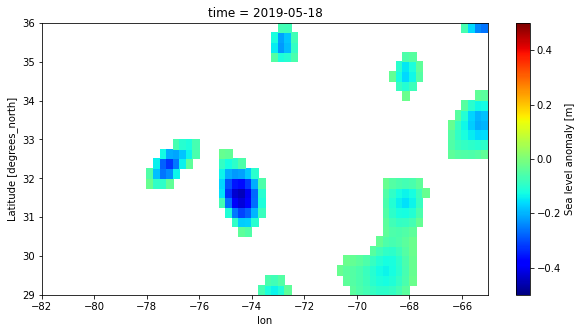

In [10]:
ds_ssh.sla.where(ds_ssh.sla[day] < -0.02)[day].plot(vmin=-.5, vmax=.5, cmap='jet', figsize=(10,5))

(array([ 2.,  3.,  2.,  2.,  7.,  3.,  4., 10., 31., 50., 40., 18., 21.,
        15., 12.]),
 array([-0.3213    , -0.27706667, -0.23283333, -0.1886    , -0.14436667,
        -0.10013333, -0.0559    , -0.01166667,  0.03256667,  0.0768    ,
         0.12103333,  0.16526667,  0.2095    ,  0.25373333,  0.29796667,
         0.3422    ]),
 <BarContainer object of 15 artists>)

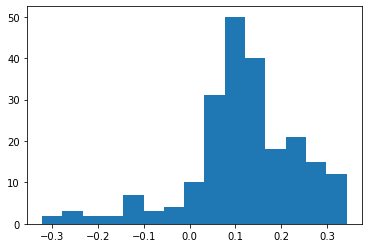

In [11]:
plt.hist(ds_cropped.sla[day].values.flatten(), bins=15)

In [12]:
import matplotlib.pyplot as plt

from skimage.measure import label
from skimage import data
from skimage import color
from skimage.morphology import extrema
from skimage import exposure

In [13]:
img = np.copy(ds_ssh.sla[day].values)

In [14]:
# We find all local maxima
local_maxima = extrema.local_minima(img)
label_maxima = label(local_maxima)
overlay = color.label2rgb(label_maxima, img, alpha=0.7, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])

In [15]:
# h = 0.05
# h_maxima = extrema.h_maxima(img, h)
# label_h_maxima = label(h_maxima)
# overlay_h = color.label2rgb(label_h_maxima, img, alpha=0.7, bg_label=0,
#                             bg_color=None, colors=[(1, 0, 0)])

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img, cmap='bwr')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[0].set_ylim(ax[0].get_ylim()[::-1])

ax[1].imshow(overlay)
ax[1].set_title('Local Maxima')
ax[1].axis('off')
ax[1].set_ylim(ax[1].get_ylim()[::-1])


ds_cropped.sla[day].plot(ax=ax[2],vmin=-.5, vmax=.5, cmap='bwr')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [17]:
ds_cropped.sla[day].values[local_maxima == True]

array([    nan,  0.0312,  0.2122,  0.2122,     nan,     nan,     nan,
        0.0628,     nan,     nan,     nan,  0.0134, -0.3213,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,  0.0851,     nan,     nan])

In [18]:
subset_minima = np.copy(local_maxima)

In [19]:
subset_minima[ds_ssh.sla[day].values > -0.02] = False

In [20]:
ds_ssh.sla[day].values[subset_minima == True]

array([-0.1335, -0.1343, -0.1527, -0.4485, -0.3213, -0.2036, -0.1637,
       -0.2243])

In [21]:
ds_ssh.sla[day].plot(vmin=-.5, vmax=.5, cmap='bwr')

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))

sla_array = np.copy(ds_ssh.sla[day].values)
sla_array[subset_minima == True] = -5
ax.imshow(sla_array, clim=(-2,2), cmap='bwr')
ax.set_ylim(ax.get_ylim()[::-1])

(-0.5, 27.5)

get locations of pixels where the cropped one isn't nan

In [23]:
r,c = np.where((subset_minima == True) & (ds_cropped.sla[day] < -0.05))
r,c

(array([13]), array([19]))

In [24]:
r = r[0]
c = c[0]

In [25]:
# r_1 = r[1]
# c_1 = c[1]

We now have some basic filtering process, if I take those points, basically lat/lon coords, and look at the neighborhood around it it should be negative all around it except for maybe one pix

In [26]:
(ds_ssh.sla[day].values[r-1:r+2,c-1:c+2]<0)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [27]:
np.sum((ds_ssh.sla[day].values[r-1:r+2,c-1:c+2]<0)) > 6

True

### Identification Loop

pandas df with

eddy_id, date, center lat/lon

then run a tracking algorithm that iterates through each eddy detected that day and basically asks for eddies within the last 2-3 days that are within 2-3 pixels
if one already exists with that ID from the same date then choose the closer one
if one does not match those conditions then create a new ID

In [359]:
#sort by depth


pix_distance_for_same_eddy = 7

#eddy_coords = list(zip(*eddy_coords))

sla_values = []
for i, coords in enumerate(eddy_coords):
    r,c = coords
    sla_values.append(ds_cropped.sla.sel(time=dt)[r,c].values)

    
coords_and_depth = list(zip(eddy_coords, sla_values))

coords_depth_sorted = sorted(coords_and_depth,key=lambda x:(x[1],x[0]))
coords_depth_sorted

[((23, 17), array(-0.2197)),
 ((8, 18), array(-0.1168)),
 ((2, 18), array(-0.1145)),
 ((22, 12), array(-0.0928)),
 ((28, 21), array(-0.0666)),
 ((18, 8), array(-0.0527))]

In [367]:
#start with the deepest eddy and delete any within 7 pix, then the next deepest remaining and go from there

pix_distance_for_same_eddy = 7

eddy_coords = list(zip(*eddy_coords))

sla_values = []
for i, coords in enumerate(eddy_coords):
    r,c = coords
    sla_values.append(ds_cropped.sla.sel(time=dt)[r,c].values)

    
coords_and_depth = list(zip(eddy_coords, sla_values))

coords_depth_sorted = sorted(coords_and_depth,key=lambda x:(x[1],x[0]))
indices_to_remove = []
for i, coords_depth in enumerate(coords_depth_sorted):
    if i not in indices_to_remove:
        coords, depth = coords_depth
        r,c = coords
        for i_1, coords_depth in enumerate(coords_depth_sorted[i+1:]):
            i_1 += i+1 # to account for the fact that we're subsetting but we want initial index locations
            print(i,i_1)
            coords, depth = coords_depth
            r_1, c_1 = coords
            dist = np.linalg.norm(np.array((r,c))-np.array((r_1,c_1)))
            print(dist)
            if dist < pix_distance_for_same_eddy:
                print('removed', i, i_1)
                indices_to_remove.append(i_1)

0 1
15.033296378372908
0 2
21.02379604162864
0 3
5.0990195135927845
removed 0 3
0 4
6.4031242374328485
removed 0 4
0 5
10.295630140987
1 2
6.0
removed 1 2
1 3
15.231546211727817
1 4
20.223748416156685
1 5
14.142135623730951


In [365]:
indices_to_remove

[3, 4, 2]

In [ ]:
for index in sorted(indices_to_remove, reverse=True):
    del eddy_coords[index]

In [360]:
eddy_coords

[(2, 18), (8, 18), (18, 8), (22, 12), (23, 17), (28, 21)]

In [183]:
import pandas as pd
columns = ['eddy_id', 'date', 'lat', 'lon']
df = pd.DataFrame(columns=columns)
df

Empty DataFrame
Columns: [eddy_id, date, lat, lon]
Index: []

In [184]:
end = datetime(day=15,month=10,year=2019) 
start= datetime(day=1,month=1,year=2019)

In [186]:
plotting=False
sla_for_cyclone = -0.02
min_neg_neighbors = 5

dt = start

for placeholder in range((end - start).days):
    # copy values to an array
    img = np.copy(ds_ssh.sla.sel(time=dt).values)

    # We find all local minima
    local_minima = extrema.local_minima(img)
    label_minima = label(local_minima)
    overlay = color.label2rgb(label_minima, img, alpha=0.7, bg_label=0,
                              bg_color=None, colors=[(1, 0, 0)])

    if plotting:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(img, cmap='bwr')
        ax[0].set_title('Original image')
        ax[0].axis('off')
        ax[0].set_ylim(ax[0].get_ylim()[::-1])

        ax[1].imshow(overlay)
        ax[1].set_title('Local Maxima')
        ax[1].axis('off')
        ax[1].set_ylim(ax[1].get_ylim()[::-1])

        ds_cropped.sla.sel(time=dt).plot(ax=ax[2],vmin=-.5, vmax=.5, cmap='bwr')

    subset_minima = np.copy(local_minima)

    print(ds_cropped.sla.sel(time=dt).values[local_minima== True])

    subset_minima[ds_ssh.sla.sel(time=dt).values > sla_for_cyclone] = False

    # now we have N pairs of coordinates of filtered eddies
    eddy_coords = np.where((subset_minima == True) & (ds_cropped.sla.sel(time=dt) < -0.03))

    print(eddy_coords)

    # iterate through the coords list and check if each pair is within N pixels of another pair
    # if it is then chose the deeper one and toss the other

    #start with the deepest eddy and delete any within 7 pix, then the next deepest remaining and go from there

    pix_distance_for_same_eddy = 7

    eddy_coords = list(zip(*eddy_coords))

    # cut out coordinates where they don't meet the # of negative neighbors
    indices_to_remove = []
    for i, coords in enumerate(eddy_coords):
        r,c = coords
        # if there are less than N neightbors that are below 0 cut it
        if np.sum((ds_ssh.sla.sel(time=dt).values[r-1:r+2,c-1:c+2]<0)) < min_neg_neighbors:
            print(r,c, 'not enough neighbors')
            indices_to_remove.append(i)

    for index in sorted(indices_to_remove, reverse=True):
        del eddy_coords[index]

    sla_values = []
    for i, coords in enumerate(eddy_coords):
        r,c = coords
        sla_values.append(ds_cropped.sla.sel(time=dt)[r,c].values)

    # join the eddy coords and depth values so they can be sorted
    coords_and_depth = list(zip(eddy_coords, sla_values))
    coords_depth_sorted = sorted(coords_and_depth,key=lambda x:(x[1],x[0]))

    indices_to_remove = []
    for i, coords_depth in enumerate(coords_depth_sorted):
        if i not in indices_to_remove:
            coords, depth = coords_depth
            r,c = coords
            for i_1, coords_depth in enumerate(coords_depth_sorted[i+1:]):
                i_1 += i+1 # to account for the fact that we're subsetting but we want initial index locations
                print(i,i_1)
                coords, depth = coords_depth
                r_1, c_1 = coords
                dist = np.linalg.norm(np.array((r,c))-np.array((r_1,c_1)))
                #print(dist)
                if dist < pix_distance_for_same_eddy:
                    print(i, 'removed', i_1)
                    indices_to_remove.append(i_1)

    for index in sorted(indices_to_remove, reverse=True):
        del coords_depth_sorted[index]

    # just get the coords back from this array
    if len(coords_depth_sorted) == 0:
        print('nothing in the coords array')
        pass
    else:
        filtered_eddy_coords = list(np.array(coords_depth_sorted)[:,0])

        if plotting:
            fig, ax = plt.subplots(figsize=(7, 7))

            sla_array = np.copy(ds_ssh.sla.sel(time=dt).values)
            sla_array[subset_minima == True] = -1.5
            sla_array[(np.isnan(ds_cropped.sla.sel(time=dt).values) == True) & (subset_minima == True)] = 5
            for coord in filtered_eddy_coords:
                sla_array[coord] = -5
            ax.imshow(sla_array, clim=(-4,4), cmap='bwr')
            ax.set_ylim(ax.get_ylim()[::-1])

        for r,c in filtered_eddy_coords:
            print('testing coords', r, c)
            # now need to run tracking algorithm
            # check dates
            df_time_subset = df[df['date'].between(dt-timedelta(days = 3), dt, inclusive=True)]

            # check locations
            lat = ds_cropped.sla.sel(time=dt)[r,c].lat.values
            lon = ds_cropped.sla.sel(time=dt)[r,c].lon.values
            df_lat_subset = df_time_subset[df_time_subset['lat'].between(lat-0.3, lat+0.3, inclusive=True)]
            df_final_subset = df_lat_subset[df_lat_subset['lon'].between(lon-0.8, lon+0.8, inclusive=True)]

            # if none exist then create a new id
            if len(df_final_subset) == 0:
                print('no matches found')
                if len(df)==0:
                    eddy_id = 0
                else:
                    eddy_id = max(df['eddy_id']) + 1
                df.loc[len(df)] = [eddy_id, dt, lat, lon]
            # only one exists, consider it the match
            elif len(df_final_subset) == 1:
                print('found one match')
                df.loc[len(df)] = [df_final_subset.iloc[0].eddy_id, dt, lat, lon]
            # if more than one exist then find the closest latitude
            elif len(df_final_subset) > 1:
                print('more than one')
                print(df_final_subset)
                # find the closest latitude in the dataframe subset
                df_closest_lat = df_final_subset.iloc[(df_final_subset['lat']-lat).abs().argsort()[:1]]
                df.loc[len(df)] = [df_closest_lat.iloc[0].eddy_id, dt, lat, lon]
    dt = dt + timedelta(days=1)

        
        

[    nan     nan     nan     nan     nan     nan  0.1897     nan     nan
     nan     nan -0.0845 -0.1173     nan     nan -0.0961     nan -0.0436
     nan     nan     nan     nan]
(array([13, 15, 19, 22]), array([12, 19, 22, 25]))
0 1
0 removed 1
0 2
0 3
2 3
testing coords 15 19
no matches found
testing coords 13 12
no matches found
testing coords 22 25
no matches found
[    nan     nan     nan     nan     nan     nan  0.1865     nan     nan
     nan     nan -0.0898 -0.1312     nan     nan -0.0946     nan     nan
     nan     nan     nan]
(array([13, 15, 19]), array([12, 19, 22]))
0 1
0 removed 1
0 2
testing coords 15 19
found one match
testing coords 13 12
found one match
[    nan     nan     nan     nan     nan  0.1844     nan     nan     nan
     nan -0.0944 -0.1406     nan -0.0929     nan     nan     nan     nan
     nan     nan]
(array([13, 15, 19]), array([12, 19, 22]))
0 1
0 2
0 removed 2
1 2
testing coords 15 19
more than one
  eddy_id       date     lat      lon
0       0 2019

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

(array([15]), array([19]))
testing coords 15 19
more than one
   eddy_id       date     lat      lon
11       0 2019-01-06  32.875  -77.125
13       0 2019-01-07  32.875  -77.125
15       0 2019-01-08  32.875  -77.125
[ 0.1228     nan     nan     nan  0.1861     nan     nan     nan  0.1413
     nan     nan     nan -0.238      nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan]
(array([15]), array([19]))
testing coords 15 19
more than one
   eddy_id       date     lat      lon
13       0 2019-01-07  32.875  -77.125
15       0 2019-01-08  32.875  -77.125
16       0 2019-01-09  32.875  -77.125
[ 0.1177     nan     nan     nan  0.1828     nan     nan     nan  0.1309
     nan     nan     nan -0.2227     nan     nan     nan     nan     nan
     nan     nan     nan     nan]
(array([15]), array([19]))
testing coords 15 19
more than one
   eddy_id       date     lat      lon
15       0 2019-01-08  32.875  -77.125
16       0 2019-01-09  32.875  -77.125
17       0 2019-0

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

(array([15, 21]), array([18, 24]))
0 1
testing coords 15 18
more than one
   eddy_id       date     lat      lon
26       0 2019-01-19  32.875  -77.375
28       0 2019-01-20  32.875  -77.375
30       0 2019-01-21  32.875  -77.375
testing coords 21 24
more than one
   eddy_id       date     lat      lon
27       3 2019-01-19  34.375  -75.625
29       3 2019-01-20  34.375  -75.875
31       3 2019-01-21  34.375  -75.875
[    nan     nan     nan     nan     nan -0.0359     nan     nan  0.0334
     nan     nan     nan     nan     nan     nan     nan -0.0935     nan
  0.0044     nan -0.0326     nan     nan     nan     nan  0.0395     nan]
(array([ 3, 15, 21]), array([ 9, 18, 24]))
0 1
0 2
1 2
testing coords 15 18
more than one
   eddy_id       date     lat      lon
28       0 2019-01-20  32.875  -77.375
30       0 2019-01-21  32.875  -77.375
32       0 2019-01-22  32.875  -77.375
testing coords 3 9
no matches found
testing coords 21 24
more than one
   eddy_id       date     lat      lon
29 

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[    nan  0.0716     nan     nan     nan     nan  0.0097     nan     nan
     nan -0.0186     nan     nan     nan     nan     nan     nan -0.0861
     nan     nan     nan     nan     nan     nan -0.032 ]
(array([16, 27]), array([18, 28]))
0 1
testing coords 16 18
more than one
   eddy_id       date     lat      lon
47       0 2019-01-30  33.125  -77.375
48       0 2019-01-31  33.125  -77.375
testing coords 27 28
no matches found
[    nan  0.0543     nan     nan     nan     nan  0.0173     nan     nan
 -0.0356     nan     nan     nan     nan     nan     nan -0.0669     nan
     nan     nan     nan     nan -0.0437]
(array([ 9, 16, 27]), array([17, 18, 28]))
9 17 not enough neighbors
0 1
testing coords 16 18
more than one
   eddy_id       date     lat      lon
47       0 2019-01-30  33.125  -77.375
48       0 2019-01-31  33.125  -77.375
49       0 2019-02-01  33.125  -77.375
testing coords 27 28
found one match
[    nan  0.0436     nan     nan     nan  0.0343     nan     nan  0.0326
 -0.0

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[ 0.0361     nan     nan     nan     nan     nan  0.0102  0.0883     nan
  0.0424     nan     nan  0.0376     nan -0.0554     nan     nan     nan
  0.083      nan     nan     nan     nan  0.035      nan]
(array([15]), array([19]))
testing coords 15 19
more than one
   eddy_id       date     lat      lon
59       6 2019-02-16  32.625  -77.625
60       6 2019-02-17  32.625  -77.625
61       6 2019-02-18  32.875  -77.375
[ 0.0345     nan     nan     nan     nan     nan -0.0019  0.0382  0.0849
     nan     nan     nan     nan  0.0358     nan -0.0628     nan     nan
     nan     nan     nan     nan     nan     nan  0.0393]
(array([15]), array([19]))
testing coords 15 19
more than one
   eddy_id       date     lat      lon
60       6 2019-02-17  32.625  -77.625
61       6 2019-02-18  32.875  -77.375
62       6 2019-02-19  32.875  -77.125
[ 0.0394     nan     nan     nan     nan -0.0056  0.0404  0.0797     nan
     nan     nan     nan  0.0309     nan -0.0772     nan     nan     nan
     nan  

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[ 0.0813     nan     nan     nan     nan     nan  0.0977  0.0387     nan
     nan     nan     nan     nan -0.2363     nan     nan     nan     nan
     nan     nan -0.0352     nan     nan     nan     nan  0.0681     nan]
(array([11, 18]), array([16, 22]))
0 1
testing coords 11 16
more than one
   eddy_id       date     lat      lon
72       7 2019-02-28  31.875  -77.875
73       7 2019-03-01  31.875  -77.875
75       7 2019-03-02  31.875  -77.875
testing coords 18 22
more than one
   eddy_id       date     lat      lon
71       6 2019-02-28  33.625  -76.375
74       6 2019-03-01  33.625  -76.375
76       6 2019-03-02  33.625  -76.375
[ 0.0834     nan     nan     nan     nan     nan  0.0925  0.0319     nan
     nan     nan     nan     nan -0.2424     nan     nan     nan     nan
     nan     nan  0.0273     nan     nan     nan     nan     nan     nan
  0.0732     nan]
(array([11]), array([16]))
testing coords 11 16
more than one
   eddy_id       date     lat      lon
73       7 2019-03-01

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[ 0.1511  0.0914     nan     nan  0.0954     nan  0.0723     nan     nan
     nan     nan -0.0103 -0.0871     nan -0.1932     nan     nan     nan
     nan     nan     nan]
(array([11, 14]), array([17, 20]))
0 1
0 removed 1
testing coords 14 20
more than one
   eddy_id       date     lat      lon
88       8 2019-03-13  32.625  -76.875
89       8 2019-03-14  32.625  -76.875
90       8 2019-03-15  32.625  -76.875
[ 0.1527  0.0808     nan     nan     nan  0.0964  0.0819     nan     nan
     nan     nan -0.0012 -0.0757     nan -0.1677     nan -0.0755     nan
     nan     nan     nan     nan]
(array([11, 14, 18]), array([17, 20, 23]))
0 1
0 removed 1
0 2
0 removed 2
testing coords 14 20
more than one
   eddy_id       date     lat      lon
89       8 2019-03-14  32.625  -76.875
90       8 2019-03-15  32.625  -76.875
91       8 2019-03-16  32.625  -76.875
[ 0.1499  0.0737     nan     nan     nan  0.1023  0.0914     nan     nan
     nan     nan  0.0115 -0.0736     nan -0.1642     nan -0.0736   

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

testing coords 12 16
more than one
    eddy_id       date     lat      lon
98       10 2019-03-22  32.125  -77.625
100      10 2019-03-23  32.125  -77.875
102      10 2019-03-24  32.125  -77.875
[-0.0272     nan     nan     nan     nan     nan     nan     nan     nan
 -0.1027     nan     nan     nan -0.1837     nan     nan     nan     nan]
(array([12, 17]), array([16, 23]))
0 1
testing coords 17 23
more than one
    eddy_id       date     lat      lon
99        9 2019-03-23  33.375  -76.125
101       9 2019-03-24  33.375  -76.125
103       9 2019-03-25  33.375  -76.125
testing coords 12 16
more than one
    eddy_id       date     lat      lon
100      10 2019-03-23  32.125  -77.875
102      10 2019-03-24  32.125  -77.875
104      10 2019-03-25  32.125  -77.875
[    nan     nan     nan -0.0284     nan     nan     nan     nan     nan
 -0.0815     nan     nan     nan     nan     nan -0.2064     nan     nan
     nan     nan     nan     nan     nan]
(array([12, 16]), array([17, 23]))
0 1
te

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

testing coords 6 12
no matches found
[    nan     nan     nan     nan -0.0138     nan -0.0189     nan -0.003
     nan     nan     nan     nan     nan -0.3576     nan     nan     nan
     nan     nan     nan -0.0214     nan]
(array([16]), array([22]))
testing coords 16 22
more than one
    eddy_id       date     lat      lon
117       9 2019-04-02  33.125  -76.125
118       9 2019-04-03  33.125  -76.125
119       9 2019-04-04  33.125  -76.375
[    nan     nan     nan -0.007      nan     nan     nan -0.0117     nan
 -0.0026     nan     nan     nan     nan     nan     nan -0.3287     nan
     nan     nan     nan     nan     nan -0.033      nan     nan]
(array([17, 24]), array([23, 27]))
0 1
testing coords 17 23
more than one
    eddy_id       date     lat      lon
118       9 2019-04-03  33.125  -76.125
119       9 2019-04-04  33.125  -76.375
121       9 2019-04-05  33.125  -76.375
testing coords 24 27
no matches found
[    nan     nan     nan     nan  0.0067     nan     nan  0.049  -0.02

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[ 0.0211     nan     nan     nan     nan     nan     nan  0.0238 -0.0256
     nan     nan  0.0494     nan  0.0685     nan     nan     nan     nan
     nan     nan  0.0348     nan     nan     nan     nan -0.0032     nan]
(array([], dtype=int64), array([], dtype=int64))
nothing in the coords array
[    nan     nan     nan     nan     nan  0.0508 -0.0239     nan     nan
  0.0522     nan  0.0616     nan     nan     nan     nan     nan  0.0773
     nan     nan     nan  0.0012     nan]
(array([], dtype=int64), array([], dtype=int64))
nothing in the coords array
[    nan     nan     nan     nan  0.1902     nan     nan  0.0731 -0.0173
     nan     nan  0.0529     nan     nan     nan     nan     nan     nan
     nan     nan  0.0811     nan     nan     nan     nan     nan]
(array([], dtype=int64), array([], dtype=int64))
nothing in the coords array
[ 0.0235     nan     nan     nan  0.1979     nan     nan -0.0114     nan
  0.0785     nan     nan     nan  0.0585     nan     nan     nan     nan
   

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

0 1
testing coords 11 16
more than one
    eddy_id       date     lat      lon
140      16 2019-05-03  31.875  -78.375
141      16 2019-05-04  31.625  -78.625
142      16 2019-05-05  31.625  -78.625
testing coords 6 8
no matches found
[ 0.0451  0.1044  0.1044     nan     nan     nan -0.047      nan -0.1971
     nan     nan     nan     nan     nan -0.0491     nan     nan     nan
     nan     nan  0.0389     nan     nan]
(array([ 6, 11, 16]), array([ 8, 17, 21]))
0 1
0 removed 1
0 2
testing coords 11 17
found one match
testing coords 6 8
found one match
[ 0.0494  0.119      nan     nan     nan -0.0527     nan -0.0928 -0.2197
     nan     nan     nan     nan     nan -0.0666     nan     nan     nan
     nan     nan     nan  0.048      nan     nan]
(array([ 6, 10, 11, 16]), array([ 8, 12, 17, 21]))
0 1
0 removed 1
0 2
0 removed 2
0 3
testing coords 11 17
more than one
    eddy_id       date     lat      lon
143      16 2019-05-06  31.875  -77.875
145      16 2019-05-07  31.875  -77.625
test

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

testing coords 13 19
more than one
    eddy_id       date     lat      lon
157      16 2019-05-14  32.125  -77.375
158      16 2019-05-15  32.125  -77.375
159      16 2019-05-16  32.375  -77.125
[    nan  0.0312  0.2122  0.2122     nan     nan     nan  0.0628     nan
     nan     nan  0.0134 -0.3213     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan  0.0851     nan     nan]
(array([13]), array([19]))
testing coords 13 19
more than one
    eddy_id       date     lat      lon
158      16 2019-05-15  32.125  -77.375
159      16 2019-05-16  32.375  -77.125
160      16 2019-05-17  32.375  -77.125
[    nan  0.0191  0.2143     nan     nan     nan     nan     nan     nan
     nan  0.0272 -0.3256     nan     nan     nan     nan     nan     nan
     nan     nan     nan  0.0867     nan     nan]
(array([13]), array([19]))
testing coords 13 19
more than one
    eddy_id       date     lat      lon
159      16 2019-05-16  32.375  -77.125
160      16 2019-05-17  32.375  -

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[    nan  0.0141     nan     nan  0.264      nan  0.0716     nan  0.0648
     nan     nan     nan     nan     nan     nan -0.0907     nan     nan
     nan     nan     nan     nan     nan     nan     nan]
(array([17]), array([22]))
testing coords 17 22
more than one
    eddy_id       date     lat      lon
173      16 2019-05-30  33.375  -76.375
174      16 2019-05-31  33.375  -76.375
175      16 2019-06-01  33.375  -76.375
[    nan     nan  0.0194     nan  0.2588     nan  0.0705     nan  0.0551
     nan     nan     nan     nan     nan     nan     nan -0.0499     nan
     nan     nan     nan     nan     nan     nan     nan     nan]
(array([17]), array([22]))
testing coords 17 22
more than one
    eddy_id       date     lat      lon
174      16 2019-05-31  33.375  -76.375
175      16 2019-06-01  33.375  -76.375
176      16 2019-06-02  33.375  -76.375
[    nan     nan  0.0156     nan  0.2526     nan     nan  0.0628     nan
  0.0639     nan     nan     nan     nan     nan     nan     nan  0

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

 10 12
more than one
    eddy_id       date     lat      lon
183      20 2019-07-22  31.375  -79.125
185      20 2019-07-23  31.625  -78.875
[    nan     nan     nan     nan -0.2328     nan     nan -0.0928     nan
 -0.137      nan     nan     nan     nan     nan     nan  0.1022     nan
     nan     nan     nan]
(array([ 4, 10, 11]), array([20, 13, 17]))
0 1
0 2
1 2
1 removed 2
testing coords 4 20
more than one
    eddy_id       date     lat      lon
184      21 2019-07-23  30.125  -76.875
186      21 2019-07-24  30.125  -76.875
testing coords 11 17
no matches found
[    nan     nan -0.2186     nan     nan     nan     nan -0.0966 -0.2112
     nan     nan     nan     nan     nan     nan     nan  0.1256     nan
     nan     nan     nan     nan]
(array([ 3, 10, 11]), array([20, 12, 18]))
0 1
0 2
1 2
1 removed 2
testing coords 3 20
more than one
    eddy_id       date     lat      lon
184      21 2019-07-23  30.125  -76.875
186      21 2019-07-24  30.125  -76.875
188      21 2019-07-25  30.

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[    nan     nan -0.2342  0.1365     nan     nan     nan     nan     nan
 -0.3756     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan]
(array([ 2, 12]), array([19, 18]))
0 1
testing coords 12 18
more than one
    eddy_id       date     lat      lon
196      22 2019-07-29  32.125  -77.625
198      22 2019-07-30  32.125  -77.375
200      22 2019-07-31  32.125  -77.375
testing coords 2 19
more than one
    eddy_id       date     lat      lon
197      21 2019-07-29  29.875  -76.875
199      21 2019-07-30  29.625  -76.875
201      21 2019-07-31  29.625  -76.875
[    nan     nan -0.2416  0.1282     nan     nan     nan     nan -0.3339
     nan     nan     nan     nan     nan     nan     nan     nan     nan]
(array([ 2, 12]), array([19, 18]))
0 1
testing coords 12 18
more than one
    eddy_id       date     lat      lon
198      22 2019-07-30  32.125  -77.375
200      22 2019-07-31  32.125  -77.375
202      22 2019-08-01  32.125  -77.375
testing coords 2 19
more th

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[    nan  0.192      nan -0.1945     nan     nan     nan     nan     nan
     nan -0.2744     nan     nan     nan  0.0717     nan     nan     nan
     nan     nan     nan     nan     nan]
(array([ 2, 15]), array([17, 21]))
0 1
testing coords 15 21
more than one
    eddy_id       date     lat      lon
210      22 2019-08-05  32.625  -76.875
212      22 2019-08-06  32.625  -76.875
214      22 2019-08-07  32.875  -76.875
testing coords 2 17
more than one
    eddy_id       date     lat      lon
211      21 2019-08-05  29.625  -77.375
213      21 2019-08-06  29.625  -77.625
215      21 2019-08-07  29.625  -77.625
[    nan  0.205      nan -0.1723     nan     nan     nan     nan     nan
     nan     nan -0.2754     nan     nan     nan  0.0409     nan     nan
     nan     nan     nan     nan     nan     nan]
(array([ 2, 15]), array([17, 21]))
0 1
testing coords 15 21
more than one
    eddy_id       date     lat      lon
212      22 2019-08-06  32.625  -76.875
214      22 2019-08-07  32.875  -7

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[ 0.2489  0.0168     nan     nan     nan -0.1174     nan     nan     nan
     nan     nan     nan -0.0887     nan     nan     nan     nan     nan
     nan     nan]
(array([ 4, 16]), array([15, 21]))
0 1
testing coords 4 15
more than one
    eddy_id       date     lat      lon
225      21 2019-08-12  29.875  -77.875
227      21 2019-08-13  30.125  -78.125
229      21 2019-08-14  30.125  -78.125
testing coords 16 21
more than one
    eddy_id       date     lat      lon
224      22 2019-08-12  32.875  -76.625
226      22 2019-08-13  32.875  -76.625
228      22 2019-08-14  32.875  -76.625
[ 0.2368  0.0211     nan     nan -0.1083     nan     nan     nan     nan
     nan     nan     nan     nan -0.0572 -0.0712     nan     nan     nan
     nan     nan     nan     nan     nan]
(array([ 4, 16, 19]), array([15, 22, 24]))
0 1
0 2
1 2
1 removed 2
testing coords 4 15
more than one
    eddy_id       date     lat      lon
227      21 2019-08-13  30.125  -78.125
229      21 2019-08-14  30.125  -78.125

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

15
more than one
    eddy_id       date     lat      lon
235      21 2019-08-17  30.125  -78.125
237      21 2019-08-18  30.125  -78.125
239      21 2019-08-19  30.125  -78.125
[    nan     nan     nan     nan -0.0666     nan     nan     nan     nan
  0.0757     nan     nan     nan  0.2491     nan     nan     nan -0.1579
     nan     nan]
(array([ 4, 20]), array([15, 24]))
4 15 not enough neighbors
testing coords 20 24
more than one
    eddy_id       date     lat      lon
236      23 2019-08-18  33.875  -75.875
238      23 2019-08-19  34.125  -75.875
240      23 2019-08-20  34.125  -75.875
[    nan     nan     nan     nan -0.0552     nan     nan     nan     nan
     nan  0.0643     nan  0.0067     nan     nan -0.1434     nan     nan
     nan     nan     nan]
(array([ 4, 20]), array([15, 24]))
4 15 not enough neighbors
testing coords 20 24
more than one
    eddy_id       date     lat      lon
238      23 2019-08-19  34.125  -75.875
240      23 2019-08-20  34.125  -75.875
242      23 201

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[ 0.1149  0.1475     nan     nan     nan     nan     nan -0.056      nan
  0.0064     nan     nan     nan     nan  0.0592     nan     nan  0.0857
     nan     nan     nan     nan     nan     nan]
(array([6]), array([16]))
testing coords 6 16
more than one
    eddy_id       date     lat      lon
265      25 2019-09-12  30.625  -77.875
266      25 2019-09-13  30.625  -77.875
267      25 2019-09-14  30.625  -77.875
[ 0.1435     nan     nan  0.1398     nan     nan     nan -0.0266     nan
  0.0356     nan     nan     nan     nan     nan     nan  0.1947     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan]
(array([], dtype=int64), array([], dtype=int64))
nothing in the coords array
[ 0.1396     nan     nan  0.1516     nan     nan     nan -0.001   0.0565
     nan     nan     nan     nan     nan     nan  0.2061     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan]
(array([], dtype=int64), array([], dtype=int64))
nothing in the coords arra

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

[ 0.025      nan     nan  0.2416     nan  0.0425     nan     nan  0.0983
     nan     nan -0.0786     nan     nan     nan     nan     nan     nan
     nan     nan]
(array([10]), array([15]))
testing coords 10 15
more than one
    eddy_id       date     lat      lon
274      27 2019-10-03  31.625  -78.125
275      27 2019-10-04  31.625  -78.125
[ 0.0222     nan     nan  0.2474     nan  0.0503     nan  0.1003     nan
     nan -0.0737     nan     nan     nan     nan     nan     nan     nan
     nan     nan]
(array([10]), array([15]))
testing coords 10 15
more than one
    eddy_id       date     lat      lon
274      27 2019-10-03  31.625  -78.125
275      27 2019-10-04  31.625  -78.125
276      27 2019-10-05  31.625  -78.125
[ 0.027      nan     nan     nan     nan  0.056      nan  0.1034     nan
     nan -0.0661     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan]
(array([10]), array([15]))
10 15 not enough neighbors
nothing in the coords array
[ 0.035      n

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

In [187]:
dt

datetime.datetime(2019, 10, 15, 0, 0)

In [188]:
df

eddy_id       date     lat      lon
0         0 2019-01-01  32.875  -77.125
1         1 2019-01-01  32.375  -78.875
2         2 2019-01-01  34.625  -75.625
3         0 2019-01-02  32.875  -77.125
4         1 2019-01-02  32.375  -78.875
..      ...        ...     ...      ...
280      27 2019-10-10  31.625  -78.125
281      27 2019-10-11  31.625  -78.125
282      27 2019-10-12  31.625  -78.125
283      27 2019-10-13  31.625  -78.125
284      27 2019-10-14  31.625  -78.125

[285 rows x 4 columns]

<AxesSubplot:>

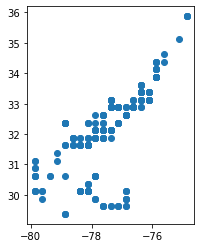

In [190]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.plot()

In [194]:
gdf

eddy_id       date     lat      lon                    geometry
0         0 2019-01-01  32.875  -77.125  POINT (-77.12500 32.87500)
1         1 2019-01-01  32.375  -78.875  POINT (-78.87500 32.37500)
2         2 2019-01-01  34.625  -75.625  POINT (-75.62500 34.62500)
3         0 2019-01-02  32.875  -77.125  POINT (-77.12500 32.87500)
4         1 2019-01-02  32.375  -78.875  POINT (-78.87500 32.37500)
..      ...        ...     ...      ...                         ...
280      27 2019-10-10  31.625  -78.125  POINT (-78.12500 31.62500)
281      27 2019-10-11  31.625  -78.125  POINT (-78.12500 31.62500)
282      27 2019-10-12  31.625  -78.125  POINT (-78.12500 31.62500)
283      27 2019-10-13  31.625  -78.125  POINT (-78.12500 31.62500)
284      27 2019-10-14  31.625  -78.125  POINT (-78.12500 31.62500)

[285 rows x 5 columns]

In [195]:
gdf.hvplot(global_extent=True, frame_height=450, tiles=True)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

In [193]:
import hvplot.pandas  # noqa

gdf.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,
                       xlim=(-180, -30), ylim=(0, 72), tiles='ESRI')

DataError: Expected Points instance to declare two key dimensions corresponding to the geometry coordinates but 0 dimensions were found which did not refer to any columns.

GeoPandasInterface expects a list of tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html

assuming I now have a list of eddies each with a lot of time,lat,lons I can zoom through the chl-a dataset and make some figs of what chl-a looks like at each step within a certain eddy

these could then easily be averaged to get some fields and I could get averages across a latitude as well as across time

In [157]:
ds = xr.open_mfdataset('oceancolour_occi/CCI_ALL-v5.0-DAILY*.nc')

In [167]:
row = next(gdf.iterrows())

In [172]:
row

(0,
 eddy_id                          0
 date           2019-05-04 00:00:00
 lat                         31.625
 lon                        -78.625
 geometry    POINT (-78.625 31.625)
 Name: 0, dtype: object)

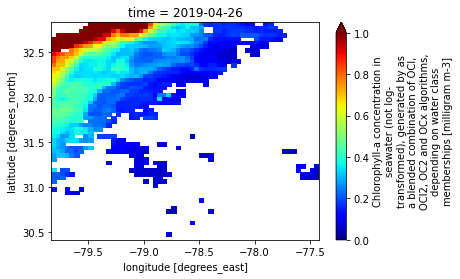

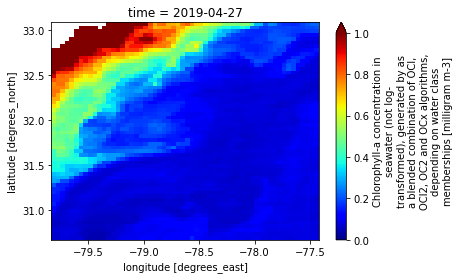

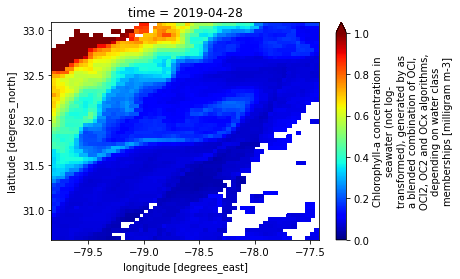

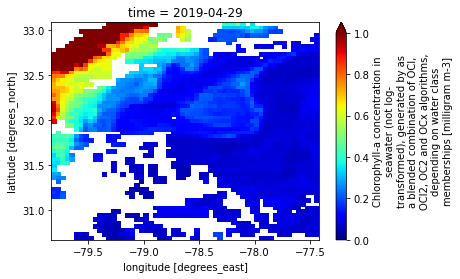

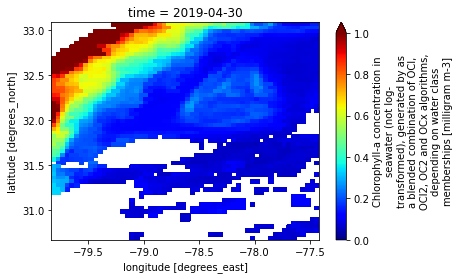

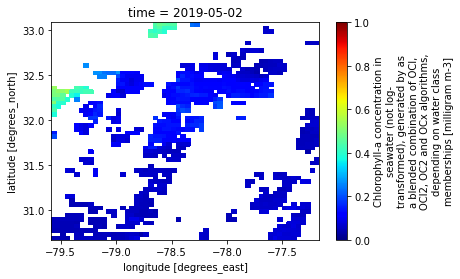

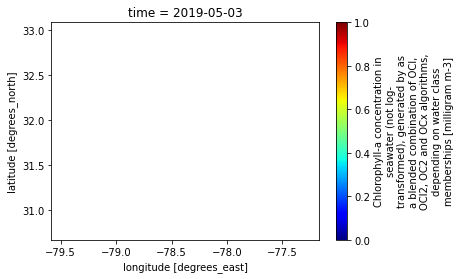

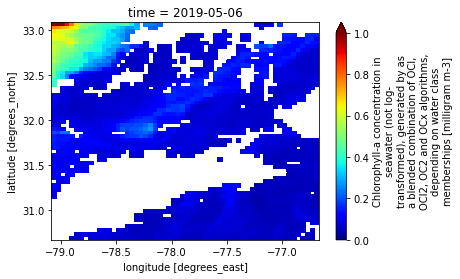

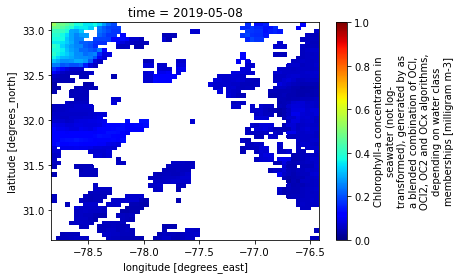

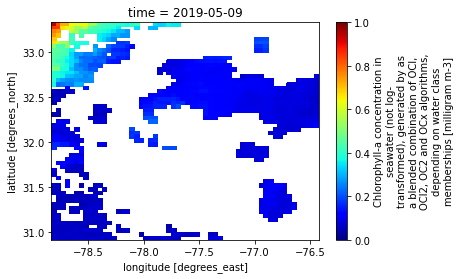

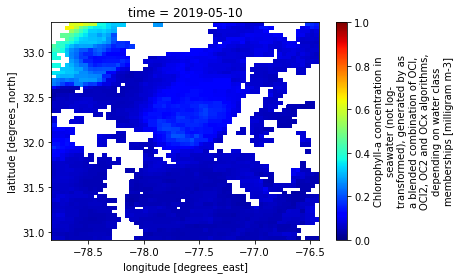

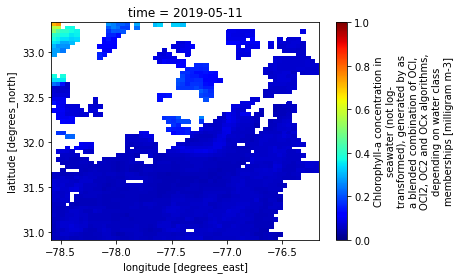

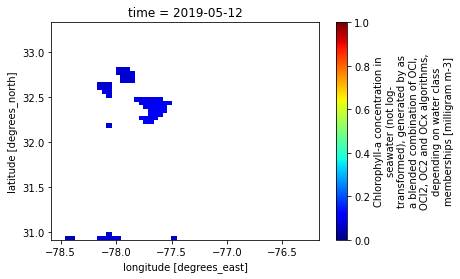

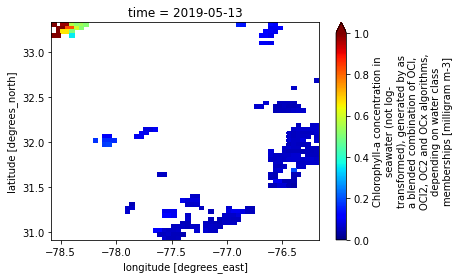

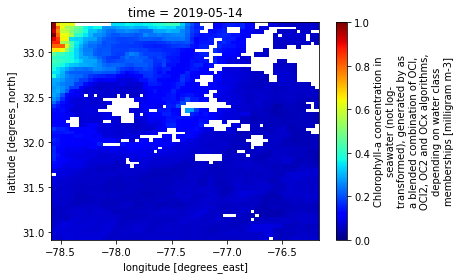

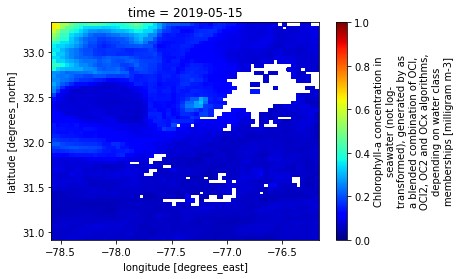

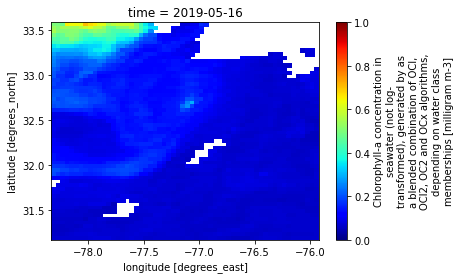

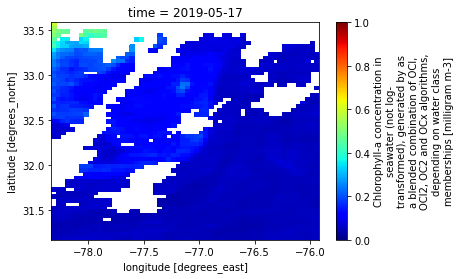

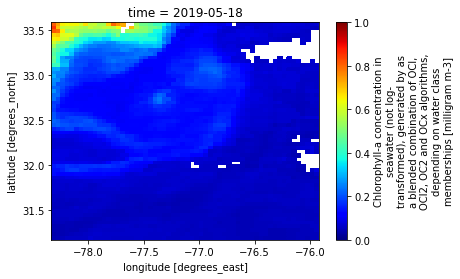

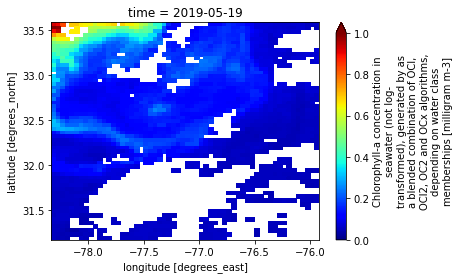

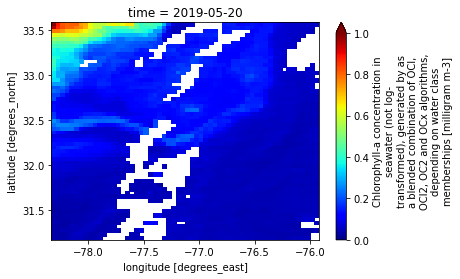

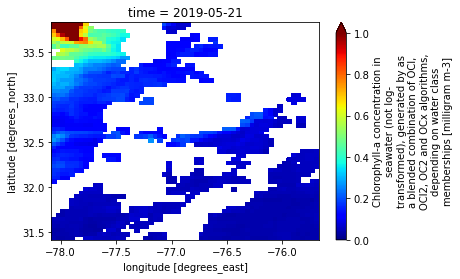

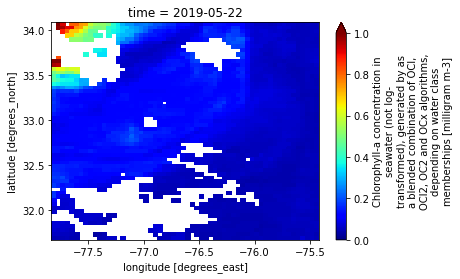

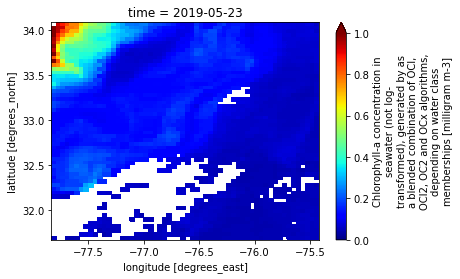

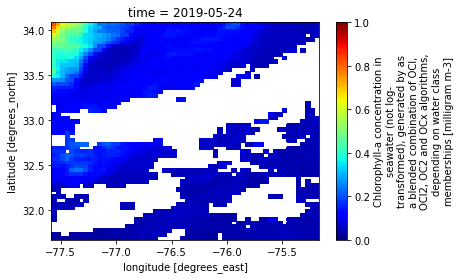

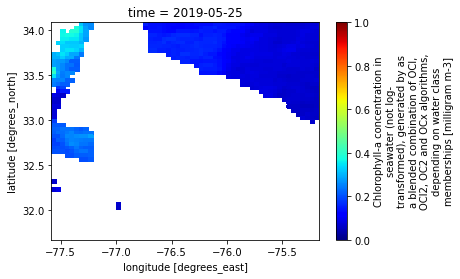

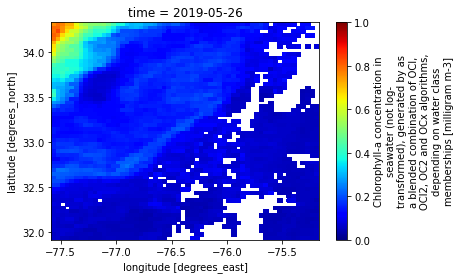

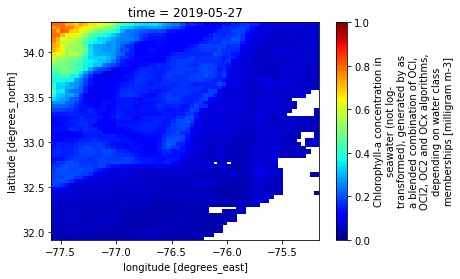

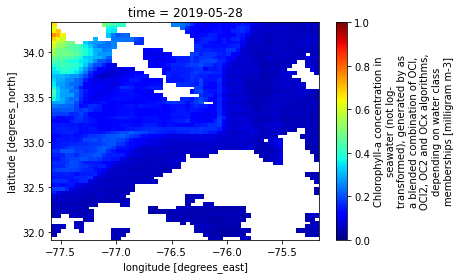

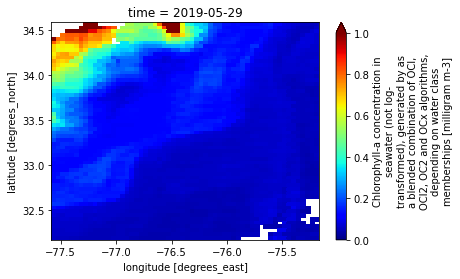

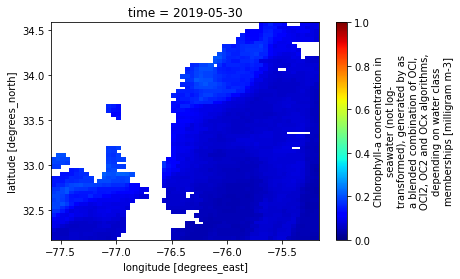

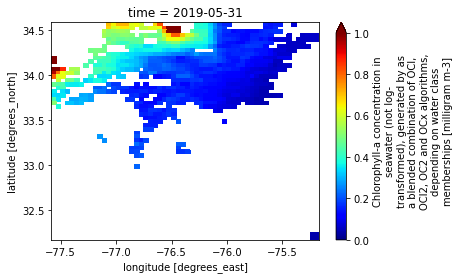

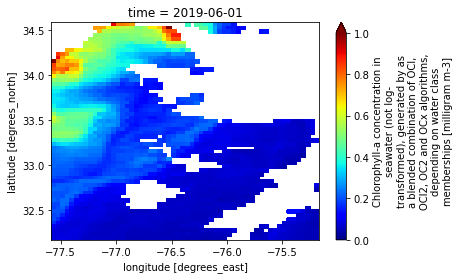

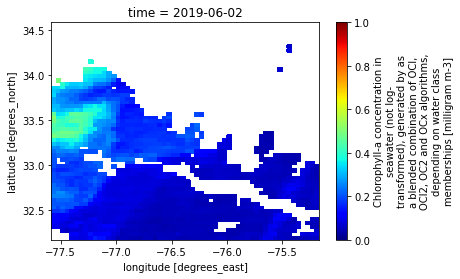

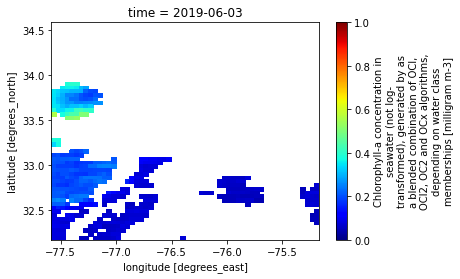

In [223]:
import matplotlib
for i, row in gdf[gdf.eddy_id == 16].iterrows():
    #print(row)
    ds.sel(time=row.date, 
           lat=slice(row.lat+1.2, 
                     row.lat-1.2), 
           lon=slice(row.lon-1.2, 
                     row.lon+1.2)).chlor_a.plot(vmin=0, vmax=1, cmap='jet')
            #norm=matplotlib.colors.LogNorm())
    plt.show()